# Image Classification - Cake or Animal

(Scene setting - Cool October Friday evening. Mid pandemic, post lockdown. Slight chance of rain. Bennie and the Jets by Elton John playing through the headset.)

In this notebook, deep learning will be used to identify if the image is a cake or an animal. This combines my 2 loves - baking and animals! I am an amature baker with lots to learn before designing realistic cakes. My favorite animals are dogs, followed by cats of course! In this day and age (hello 2020 pandemic, I'm looking at you) of fabulous bakers creating cakes that look suprisingly life like, sometimes I wonder if I AM made of cake! (lousy joke, please forgive me!) I would like to know if the image I'm looking is in fact an animal or a cake that I can consume. I thus have employed deep learning to help me with task.

The notebook follows the FastAI version 2 based on the fastbooks provided by [Jeremy Howard](https://course.fast.ai/videos/?lesson=2). The model will be put into "production" (goodness gracious so fancy!) using Violà and Docker. 

In [1]:
from fastbook import *
from fastai.vision.widgets import *

To download images, use API key for Bing Image Search

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '118f2589079f460cb8965f328f0abd19')

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

Now download images of realistic animal cakes

In [4]:
dest = 'images/cake'
results = search_images_bing(key, 'realistic animal cakes')
img = results.attrgot('content_url')
len(img)

150

150 image URLS from bing have been successfully downloaded. From the URLs, download the images in the pre-created folder 'cake' within the 'images' directory.

In [5]:
download_images(dest, urls=results.attrgot('content_url'))

Test the first image downloaded

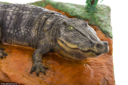

In [6]:
ck = get_image_files('images/cake')
img = Image.open(ck[0])
img.to_thumb(128,128)

Similarly download animal images into the 'animal' folder

In [7]:
dest = 'images/animal'
results = search_images_bing(key, 'animal')
img = results.attrgot('content_url')
download_images(dest, urls=results.attrgot('content_url'))

Test the first image

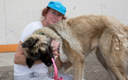

In [8]:
ck = get_image_files('images/animal')
img = Image.open(ck[0])
img.to_thumb(128,128)

Now that the images have been downloaded, check to see if any of the images are corrupt.

In [9]:
file = 'cake', 'animal'
path = Path('images')
for i in file:
    dest = (path/i)
    fns = get_image_files(dest)
    failed = verify_images(fns)
    print(failed)

(#2) [Path('images/cake/00000001.jpg'),Path('images/cake/00000127.jpg')]


(#0) []


Unlink the corrupt images from the 'cake' folder.

In [10]:
fns = get_image_files('images/cake')
failed = verify_images(fns)
failed.map(Path.unlink);

## Data Preparation

Now that the data has been downloaded, it needs to be made available in a format that would suit training the FastAI model. To do so, we create a DataBlock object as a template for a DataLoader.

In [20]:
items = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # ImageBlock is the independent variable (images), CategoryBlock is dependent(type of image)
    get_items=get_image_files, # image files to be opened from path recurrsively
    splitter=RandomSplitter(valid_pct=0.2, seed=1224), # 80-20 split to train and valid datasets
    get_y=parent_label, # name of the parent file will be the label
    item_tfms=Resize(128)) # resize image

Now that the data block has been created, supply the data to the block to create a DataLoader object. Start by providing the path for all the images.

In [21]:
dls = items.dataloaders(path)

View the content of the DataLoader object

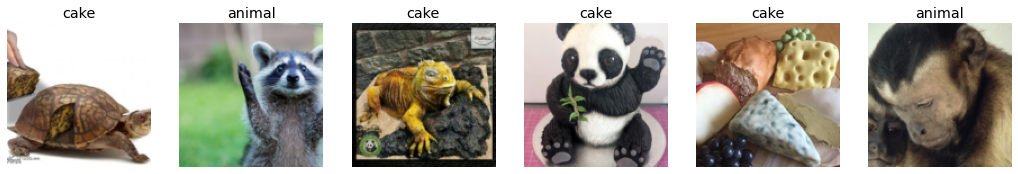

In [22]:
dls.valid.show_batch(max_n=6, nrows=1)

The images can be padded along to borders to reduce the loss of details.

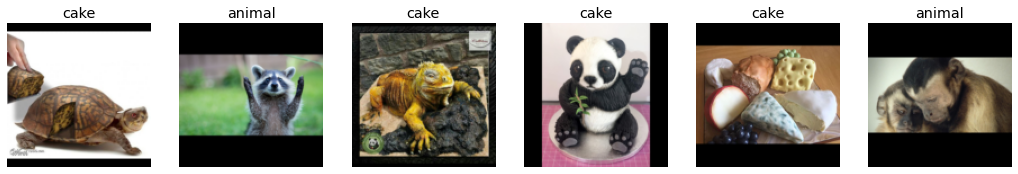

In [23]:
items = items.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')) # new() updates the datablock
dls = items.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

The padding introduces quite a lot of empty spaces. To ensure our model works efficiently, the images can be randomnly cropped. Each epoch while training the model will see different part of the images to identify various features of the image. Just like with reCAPTCHA an image is cut up in parts to identify different items within it.

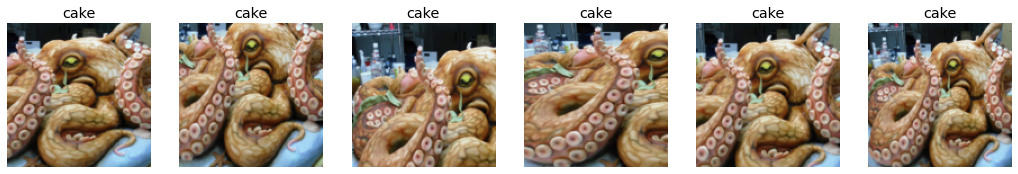

In [24]:
items = items.new(item_tfms=RandomResizedCrop(128, min_scale=0.4))
dls = items.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=1, unique=True)

As can be seen, various aspects of the image have been focused on in different images. Since the data set is small (150 images per category), we can use the randomly reseized cropped images for training the model. Also how terrifying yet tasty looking is this cake! 

## Train Model

Create Learner using the DataLoaders object and 'resnet18' - a CNN of 18 layers and 8 epochs.

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.351718,0.701880,0.305085,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.842161,0.464346,0.220339,00:07
1,0.751904,0.391996,0.135593,00:06
2,0.634025,0.411123,0.135593,00:07
3,0.553820,0.468701,0.135593,00:07
4,0.474727,0.474185,0.135593,00:06
5,0.411813,0.472460,0.135593,00:06
6,0.361942,0.473995,0.135593,00:06
7,0.337801,0.464858,0.118644,00:06


The error rate metric shows a decrease in error as the epoch number increases. The accuracy (1-error_rate) is 0.882 or 88.2%. Using the confusion matrix, we can test the model efficiency.

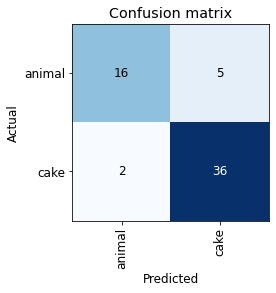

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

5 animals were misclassified as cake and 2 cakes was misclassified as an animal. The 2 misclassified cakes must have been quite realistic cakes! This could mean a problem in the dataset. We can plot the top losses and elimate those that reperesent bad data.

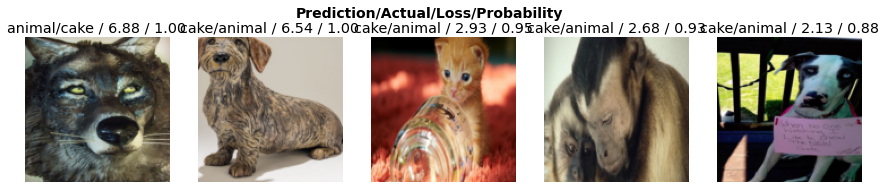

In [29]:
interp.plot_top_losses(5, nrows=1)

The model shows the images that should not belong to the dataset, thus being misclassified. Using the ImageClassifierCleaner widget, these images can be removed to then be used to re-train the model.

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Now that the images to delete have been selected, it can be unlinked from the file.

In [41]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [36]:
# For images whose classes have been changed
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now rerun the model with the cleaner dataset.

In [43]:
dls = items.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.259375,1.868632,0.433962,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.607747,0.521146,0.226415,00:07
1,0.588310,0.259825,0.094340,00:05
2,0.499883,0.218711,0.075472,00:06
3,0.416772,0.191490,0.056604,00:05
4,0.369287,0.186150,0.056604,00:05


As can be seen, the error rate has reduced even more, with the model predicting at 94.4% accuracy. The accuracy has impoved by 6% with cleaned data. Jeremy Howard and Sylvain Gugger have suggested that the model could achieve 100% with absolutely clean data.

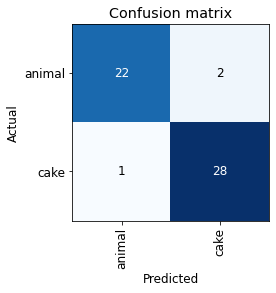

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Only 3 images were misclassified, which can be seen below.

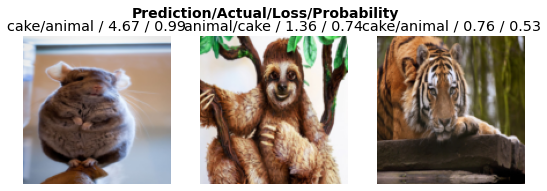

In [47]:
interp.plot_top_losses(3, nrows=1)

The model can be tested before exporting.

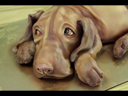

In [48]:
results = search_images_bing(key, 'realistic dog cakes')
ims = results.attrgot('content_url')
len(ims)

dest = 'images/test.png'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

The image of this cake shows a very realistic dog. Kudos to the baking artist! Lets see if the model can classify it correctly.

In [53]:
pred,pred_idx,probs = learn.predict('images/test.png')

print(f'The model predicts the image to be {pred} with the probability of {probs[pred_idx]:.04f}')

The model predicts the image to be cake with the probability of 0.9987


It is now safe to consume this cake and export the model into production!

## Export Model

Exporting the model will create a '.pkl' object file which can be exported to a production server. 

In [58]:
learn.export()

The exported model sits in the home directory. It can also be imported into another notebook to use.

In [55]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

To check the number of classes the model is trained on, you can check the vocabulary

In [59]:
learn_inf.dls.vocab

(#2) ['animal','cake']

One way of providing a proof of concept is render the notebook using *Voilà*. Once the notebook is on Github, it can be rendered using *[Binder](https://mybinder.org/)*. To make sure the notebook has *Voilà* run the following code.

In [60]:
#!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.3 OK


Since I'm using Paperspace to host my notebook, there are two ways to render the notebook. On installing *Voilà*, a button to render the notebook was added at the end to the ribbion of options. 

<img src="Voila_button.png">

Either click this or replace 'notebooks' in the URL with 'voila/render' which converts the notebook into HTML page of sorts. Now that this notebook is on GitHub, *Binder* will be used for a quick prototype. This will also be put onto a Docker image.

Hope you enjoyed this journey as much as I did. Wear a mask. Tip your delivery people and your waiter/ress. Stay safe!